# Supernova Model Fitting
In this notebook, we fit SN models to synthetic supernovae.

In [1]:
%load_ext autoreload
%autoreload 2

from lightkurve import KeplerTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
#import sncosmo
%matplotlib inline
from lightkurve.injection import SupernovaModel

In [2]:
tpf = KeplerTargetPixelFile.from_archive(220381074) 

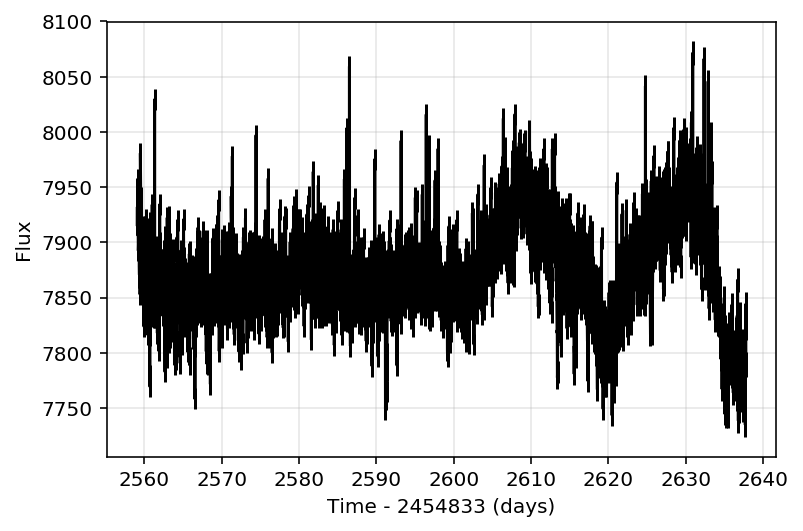

In [3]:
lc = tpf.to_lightcurve(aperture_mask='all') 
lc = lc.remove_nans().remove_outliers() 
lc.plot(normalize=False)

In [4]:
import lightkurve.injection as inj

We are injecting a supernova into this light curve.

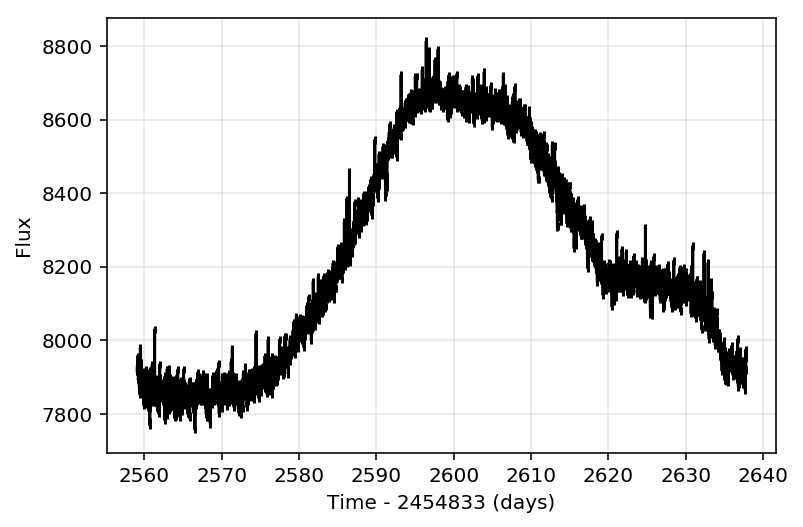

In [5]:
model = inj.SupernovaModel(T0=2600, source='hsiao', bandpass='kepler', z=0.5, amplitude=5e-8)
lcinj = inj.inject(lc, model)
lcinj = lcinj.remove_nans()
lcinj.plot(normalize=False)

Likelihood:  
$p(y\mid\theta)$

Prior:  
$p(\theta)$

Posterior Probability Density Distribution Function (PDF):  
$p(\theta\mid y) \propto p(y\mid\theta) \cdot p(\theta)$

For MCMC sampling, we will directly compute the posterior PDF. For optimization, we will *merely* find the maximum likelihood - in other words, the single value for $\theta$ (eg. $m, b$) that maximizes the likelihood function.  The convention in optimization is to seek the minimum value of the input function.  Accordingly, we must multiply the likelihood function by -1 so that the maximum likelihood corresponds to the minimum.

We want to compute the maximum a posteriori estimation, $\hat\theta_{map}$.


In [6]:
#wavelength = np.array([500., 10000., 19500., 29000., 38500., 48000.])
#transmission = np.array([0., 1., 1., 1., 1., 0.])
#all_band = sncosmo.Bandpass(wavelength, transmission, name='all')

def ln_like(theta):
    T0, z, amplitude, background = theta
    if (z < 0) or (z > 1) or (T0 < np.min(lc.time)) or (T0 > np.max(lc.time)):
        return -1.e99
    model = SupernovaModel(T0, z=z, amplitude=amplitude, bandpass='kepler')
    model = model.evaluate(lcinj.time) + background
    inv_sigma2 = 1.0/(lcinj.flux_err**2)
    chisq = (np.sum((lcinj.flux-model)**2*inv_sigma2))
    lnlikelihood = -0.5*chisq
    return lnlikelihood


In [7]:
def neg_ln_like(theta):
    return -1 * ln_like(theta)

In [8]:
def lnprior(theta):
    T0, z, amplitude, background = theta
    if z < 0 or z > 1:
        return 0.0
    return -np.inf

Optimization can't handle infinity values, so we redefine a lnprior that returns very large numbers instead of infinity.

In [9]:
def lnprior_optimization(theta):
    T0, z, amplitude, background = theta
    if (z < 0) or (z > 1):
        return -1.e99
    return 0.0

In [10]:
def ln_posterior(theta):
    lp = lnprior(theta)
    return lp + ln_like(theta)

In [11]:
def neg_ln_posterior(theta):
    log_posterior = lnprior_optimization(theta) + ln_like(theta)
    return -1 * log_posterior

Run the optimization:

In [13]:
import scipy.optimize as op

In [14]:
xmin = [2500., 0.0, 1.e-8, None]
xmax = [2700., 2.0, 9.e-8, None]

# rewrite the bounds in the way required by L-BFGS-B
bounds = [(low, high) for low, high in zip(xmin, xmax)]

In [15]:
%%time
#Injected values: T0=2600, z=0.5, amplitude=5e-8
x0 = [2610, 0.5, 3.0e-8, np.percentile(lc.flux, 3)]

result = op.minimize(neg_ln_posterior, x0)

CPU times: user 1min 56s, sys: 6.53 s, total: 2min 3s
Wall time: 33.4 s


In [16]:
print(result)
T0_f, z_f, amplitude_f, background_f = result["x"]

      fun: 97802.78601310786
 hess_inv: array([[ 8.56484461e-05,  3.40216750e-06,  2.30167395e-14,
         9.68713565e-05],
       [ 3.40216750e-06,  3.71249856e-07,  1.11271108e-14,
        -4.84711888e-05],
       [ 2.30167395e-14,  1.11271108e-14,  1.21428211e-21,
        -8.09025197e-12],
       [ 9.68713565e-05, -4.84711888e-05, -8.09025197e-12,
         7.88942383e-02]])
      jac: array([ 4.17379531e+04, -1.67136124e+05,  9.87250131e+12, -1.03748730e+03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 271
      nit: 4
     njev: 43
   status: 2
  success: False
        x: array([2.60348162e+03, 6.36471967e-01, 4.84868129e-08, 7.86661271e+03])


Interesting, it returned new values but warns of precision loss.  The MAP parameters seem to be close to the input values.  Let's overplot the model and data to see how they compare.

In [17]:
T0_f, z_f, amplitude_f, background_f
new_model = inj.SupernovaModel(T0=T0_f, source='hsiao', bandpass='kepler', z=z_f, amplitude=amplitude_f)
byeye_model = inj.SupernovaModel(T0=2610, source='hsiao', bandpass='kepler', z=1, amplitude=5.0e-8)
new_fit = new_model.evaluate(lc.time) + background_f
byeye_fit = byeye_model.evaluate(lc.time) + 7800

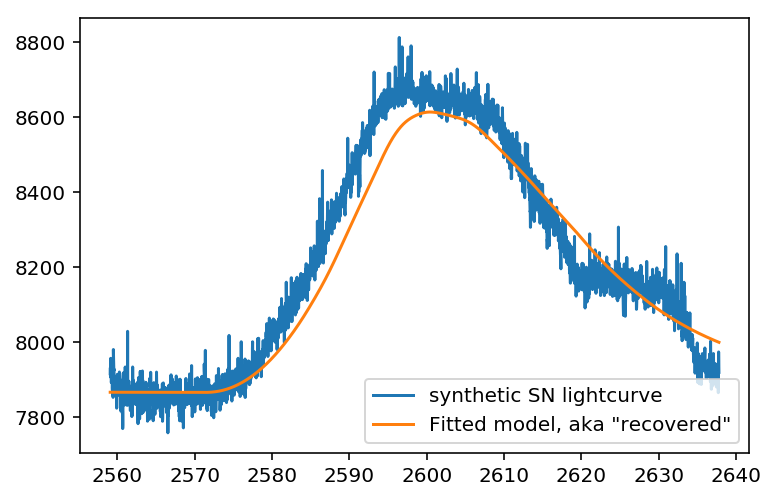

In [19]:
plt.plot(lcinj.time, lcinj.flux, label='synthetic SN lightcurve')
plt.plot(lcinj.time, new_fit, label = 'Fitted model, aka "recovered"')
#plt.plot(lcinj.time, byeye_fit, label = 'By eye fit')
plt.legend()

Hmm, suspicious-- the optimization "worked" but returned the input values.  How can this be?  Let's debug by plotting "chi-sq contours".  We'll see if a minus sign is wrong somewhere.

In [39]:
amp_arr = np.logspace(1.0e-10, 1.0e-6, 50)

In [40]:
2610, 0.5, 3.0e-8, np.percentile(lc.flux, 3)

(2610, 0.5, 3e-08, 7789.7870898437495)

In [41]:
chisqs = amp_arr*0.0
for i, amp in enumerate(amp_arr):
    chisq = neg_ln_posterior([2610, 0.5, amp, 7800])
    chisqs[i] = chisq

In [42]:
chisqs

array([1.40039047e+21, 1.40039060e+21, 1.40039074e+21, 1.40039087e+21,
       1.40039100e+21, 1.40039113e+21, 1.40039126e+21, 1.40039139e+21,
       1.40039153e+21, 1.40039166e+21, 1.40039179e+21, 1.40039192e+21,
       1.40039205e+21, 1.40039218e+21, 1.40039231e+21, 1.40039245e+21,
       1.40039258e+21, 1.40039271e+21, 1.40039284e+21, 1.40039297e+21,
       1.40039310e+21, 1.40039324e+21, 1.40039337e+21, 1.40039350e+21,
       1.40039363e+21, 1.40039376e+21, 1.40039389e+21, 1.40039403e+21,
       1.40039416e+21, 1.40039429e+21, 1.40039442e+21, 1.40039455e+21,
       1.40039468e+21, 1.40039482e+21, 1.40039495e+21, 1.40039508e+21,
       1.40039521e+21, 1.40039534e+21, 1.40039547e+21, 1.40039560e+21,
       1.40039574e+21, 1.40039587e+21, 1.40039600e+21, 1.40039613e+21,
       1.40039626e+21, 1.40039639e+21, 1.40039653e+21, 1.40039666e+21,
       1.40039679e+21, 1.40039692e+21])

In [60]:
print(result.x)

[2.59e+03 4.00e-01 2.60e-08]


In [61]:
model_fit = inj.SupernovaModel(T0=result.x[0], source='hsiao', bandpass='kepler', z=result.x[1], amplitude=result.x[2])
model_fit = model_fit.evaluate(lc.time)

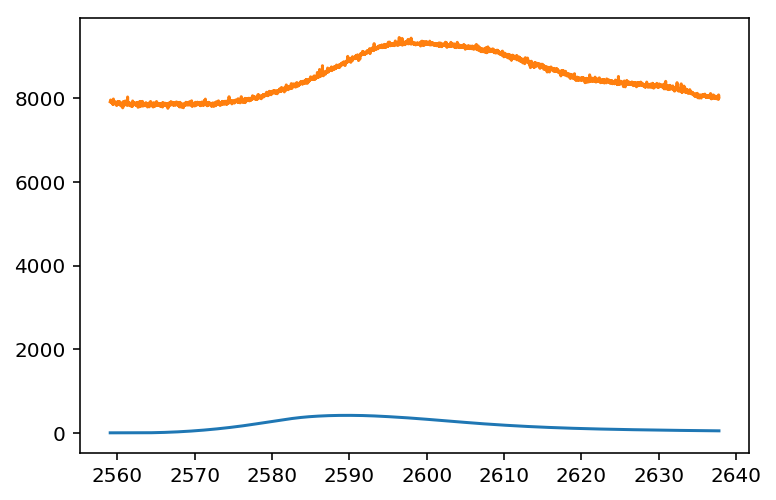

In [62]:
lcinj.normalize()
plt.plot(lc.time, model_fit)
plt.plot(lc.time, lcinj.flux)

In [272]:
ndim, nwalkers = 3, 100
pos = [[2600, 0.5, 2.e-8] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [273]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=4)

emcee: Exception while calling your likelihood function:
  params: [ 2.59889717e+03 -6.39128583e-01 -2.56682532e+00]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/sheilasagear/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-270-d1446d9719e9>", line 3, in lnprob
    return lp + neg_ln_like(theta)
  File "<ipython-input-268-f4b31da96a10>", line 8, in neg_ln_like
    model = model.evaluate(x)
  File "/Users/sheilasagear/github/lightkurve/lightkurve/injection.py", line 243, in evaluate
    band_intensity = model.bandflux(self.bandpass, time)  #Units: e/s/cm^2
  File "/Users/sheilasagear/anaconda2/lib/python2.7/site-packages/sncosmo/models.py", line 1339, in bandflux
    raise e
ValueError: bandpass 'kepler' [3640, .., 9190] outside spectral range [360.871, .., 9021.79]


In [274]:
%%time
mcmc_result = sampler.run_mcmc(pos, 2000)

ValueError: bandpass 'kepler' [3640, .., 9190] outside spectral range [360.871, .., 9021.79]

#### 